# RTED-TDS Co-Sim

Test parameters of AGC when there is EV2 but no EVA.

## Import case

In [1]:
import os
os.chdir('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import andes
from andes.interop.pandapower import to_pandapower, make_link_table, runopp_map
from andes.interop.pandapower import add_gencost
andes.config_logger(stream_level=20)

import pandapower as pp

from jams import rted2, rted3

from ev_ssm import ev_ssm

print(andes.__version__)
print(pp.__version__)

caseH = 10

# --- ANDES case ---
dir_path = os.path.abspath('..')
case_path = '/case/ieee39_ev2.xlsx'
case = dir_path + case_path
ssa = andes.load(case, 
                 setup=True,
                 no_output=True,
                 default_config=False)

# Set output mode as 'manual', turn off TDS progress bar
ssa.TDS.config.save_mode = 'manual'
ssa.TDS.config.no_tqdm = 1

# Set load as constant load.
ssa.PQ.config.p2p = 1
ssa.PQ.config.q2q = 1
ssa.PQ.config.p2z = 0
ssa.PQ.config.q2z = 0
ssa.PQ.pq2z = 0

# Turn on ``numba`` can accelerate TDS.
ssa.config.numba = 1


Working directory: "/home/jwang175/andes/jwang/notes"
> Loaded config from file "/home/jwang175/.andes/andes.rc"


0.post4491.dev0+g14fac50
2.9.0


> Loaded generated Python code in "/home/jwang175/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 6 processes.


Saved generated pycode to "/home/jwang175/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.3322 seconds.
Parsing input file "/home/jwang175/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.1148 seconds.
System internal structure set up in 0.0506 seconds.


ANDES total load is: 58.564 p.u.


Text(0.5, 0, 'Time [s]')

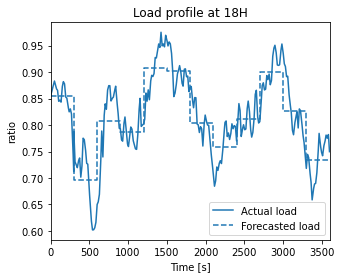

In [2]:
# --- read load from ssa ---
ptotal = ssa.PQ.as_df()['p0'].sum()
print('ANDES total load is:',ptotal.round(4),'p.u.')

# --- scale load curve ---
ddata_path = '/case/dsyn.csv'
ddata = dir_path + ddata_path
d_syn = pd.read_csv(ddata)

caseH = 18

np.random.seed(2022)
col = ['h10', 'h18', 'a10', 'a18']
col1 = ['h10', 'h18']
col2 = ['a10', 'a18']
# d_syn['a10'].iloc[200:650] *= 0.5
d_syn[col1] = (d_syn[col1] - d_syn[col1].min()) / d_syn[col1].min() + 0.8
d_syn[col2] = (d_syn[col2] - d_syn[col2].mean()) / (d_syn[col2].max() - d_syn[col2].min())

if caseH == 10:
    k = 0.4  # the coefficient can be adjusted to fit the case
    d_syn['s10'] = d_syn['h10'] + k * d_syn['a10']
    d_syn['s18'] = d_syn['h18'] + k * d_syn['a18']
    d_syn['sload'] = d_syn['s10']
    # d_syn['sload'] = d_syn['sload'].rolling(10).mean().interpolate(method='polynomial', order=1, inplace=False)
    # d_syn['sload'].iloc[0:310] -= 0.05 * k / 0.3
    # # d_syn['sload'].iloc[250:350] = None
    # # d_syn['sload'].iloc[250:350].interpolate(method='polynomial', order=3, inplace=True)
    # d_syn['sload'].iloc[400:650] += 2 * (0.8 - d_syn['sload'].iloc[300:600])
    # d_syn['sload'].iloc[600:900] += 0.02 * k / 0.3
    # # d_syn['sload'].iloc[450:650] = None
    # # d_syn['sload'].iloc[450:650].interpolate(method='polynomial', order=9, inplace=True)
    # d_syn['sload'].iloc[900:1200] += 0.03 * k / 0.3
    # d_syn['sload'].iloc[1200:1800] -= 0.06 * k / 0.3
    # d_syn['sload'].iloc[2100:2400] += 0.02 * k / 0.3
    # d_syn['sload'].iloc[2700:3000] -= 0.03 * k / 0.3
    # d_syn['sload'].iloc[3300:3600] += 0.05 * k / 0.3
if caseH == 18:
    k = 0.4  # the coefficient can be adjusted to fit the case
    d_syn['s10'] = d_syn['h10'] + k * d_syn['a10']
    d_syn['s18'] = d_syn['h18'] + k * d_syn['a18']
    d_syn['sload'] = d_syn['s10']
    d_syn['sload'].iloc[0:300] -= 0.2 * k
    # d_syn['sload'].iloc[200:700] = d_syn['sload'].iloc[200:700].rolling(80).mean()

    # d_syn['sload'] = d_syn['sload'].rolling(10).mean().interpolate(method='polynomial', order=1, inplace=False)
    # d_syn['sload'].iloc[100:600] = d_syn['sload'].iloc[100:600].rolling(10).mean().interpolate(method='polynomial', order=1, inplace=False)

# calculate expected load
step = 300
d_exp = d_syn.groupby(d_syn.index // step).mean().copy()
d_exp['time'] = range(0,3600,300)

# # align starting point of load with starting point of dispatch results
d_syn['sload'].iloc[0] = d_exp['sload'].iloc[0]
d_syn['sload'].iloc[1:50] = None
d_syn['sload'].interpolate(method='linear', inplace=True)

# --- plot load curve ---
fig_load, ax_load = plt.subplots(figsize=(5, 4))
ax_load.plot(d_syn['time'], d_syn['sload'], color='tab:blue', linestyle='-')
ystep = list(d_exp['sload'])
ystep.insert(0, d_exp['sload'].iloc[0])
ax_load.step(range(0,3900,300), ystep, color='tab:blue', linestyle='--')
ax_load.set_xlim([0, 3600])
ax_load.legend(['Actual load', 'Forecasted load'])
ax_load.set_title(f'Load profile at {caseH}H')
ax_load.set_ylabel('ratio')
ax_load.set_xlabel('Time [s]')


<AxesSubplot:>

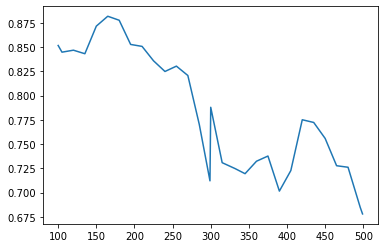

In [3]:
d_syn['sload'].iloc[100:500].plot()

<AxesSubplot:>

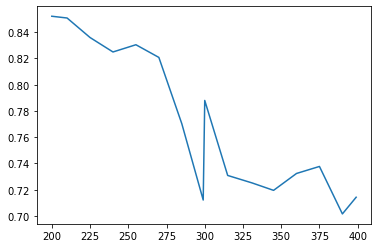

In [4]:
d_syn['sload'].iloc[200:400].plot()

## Setup ``ssp`` and ``ssd``

In [5]:
# --- set up EV generator data ---
ev_idx = 'PV_10'
ssa.PV.set(src='p0', idx=ev_idx, attr='v', value=30 / ssa.config.mva)
ssa.PV.set(src='pmax', idx=ev_idx, attr='v', value=99999 / ssa.config.mva)
ssa.PV.set(src='pmin', idx=ev_idx, attr='v', value=-99999 / ssa.config.mva)

# --- setup pandapower: ssp ---
ssp = to_pandapower(ssa)

# set EV generator as uncontrollable
ssp.gen.controllable.iloc[9] = False

# add gen cost, unit: $/MWh; G1-11. G10 EV, G11 Slack; 
# set EV as -10, for the cost of SFR mileage
c1 = [20, 20, 20, 20, 20, 20, 20, 20, 20, -10, 20]
c0 = [500, 380, 42, 380, 295, 400, 350, 330, 490, 0000, 550]
c2 = [0.014, 0.020, 0.194, 0.020, 0.0255, 0.0210, 0.230, 0.0222, 0.0150, 0.000, 0.0300]
gen_cost = np.array([[2., 0., 0., 3., 0., 0., 0.]] * ssp.gen.shape[0])
gen_cost[:, 4] = np.array(c2) / ssa.config.mva
gen_cost[:, 5] = np.array(c1) / ssa.config.mva
gen_cost[:, 6] = np.array(c0) / ssa.config.mva

add_gencost(ssp, gen_cost)

# --- setup RTED: ssd ---
ssd = rted3(name='RTED', OutputFlag=0)
ssd.from_andes(ssa)
ssd.build()

# set EV generator as uncontrollable
ssd.gen.ctrl.loc[ev_idx] = 0

# set EV geenrator as type2
prumax = 0
prdmax = 0
ssd.def_type2([ev_idx], [prumax], [prdmax])

# Case data comes from a MPCE
# https://ieeexplore.ieee.org/document/9018441
# set ramp_5
ramp_15 = [156, 120, 130, 110, 80, 105, 90, 90, 150, 99999, 200]
# ramp_hour = [80, 80, 80, 50, 50, 50, 30, 30, 30, 999, 30]
ssd.gen['ramp_5'] = 10 * np.array(ramp_15) / 3 / ssd.mva

# set cost
ssd.cost['c1'] = c1
ssd.cost['c2'] = c2
ssd.cost['c0'] = c0

# adjust SFR cost of EV lower than SynGen
ssd.cost['cru'] = [0] * ssd.gen.shape[0]
ssd.cost['cru'].loc[ev_idx] = -1
ssd.cost['crd'] = ssd.cost.cru

# --- benchmark ssd with ssp using DCOPF ---
pp.rundcopp(ssp)
dc_comp = ssp.res_gen.copy()
gb_res = ssd.solve(disable_sfr=True, disable_ramp=True, info=False)
dc_comp['p_mw(GB)'] = ssd.mva * gb_res['pg'].values
print(f"pp cost={ssp.res_cost}, gb cost={ssd.res_cost}")


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.1614 seconds.
0: |F(x)| = 7.801234474
1: |F(x)| = 3.497456094
2: |F(x)| = 0.1830765786
3: |F(x)| = 0.0007183022492
4: |F(x)| = 1.659284843e-08
Converged in 5 iterations in 0.0177 seconds.
Power flow results are consistent. Conversion is successful.


Restricted license - for non-production use only - expires 2023-10-25


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0174 seconds.
0: |F(x)| = 7.801234474
1: |F(x)| = 3.497456094
2: |F(x)| = 0.1830765786
3: |F(x)| = 0.0007183022492
4: |F(x)| = 1.659284843e-08
Converged in 5 iterations in 0.0113 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.
RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED limited: sfru, sfrd
RTED: total cost=4889.131


pp cost=2184.5741560778915, gb cost=4889.131241556355


In [6]:
dc_comp

,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,970.031255,39.975645,15.883073,1.0,970.031250
1,645.999994,228.920849,2.228140,1.0,646.000000
2,290.000000,81.098706,-0.865261,1.0,290.000000
3,651.999992,114.224547,7.298529,1.0,652.000000
4,507.999994,137.957637,5.467236,1.0,508.000000
5,646.687502,212.087094,6.419596,1.0,646.687500
6,232.000000,55.288376,3.437886,1.0,232.000000
7,563.999997,-59.894996,13.953432,1.0,564.000000
8,864.999994,49.876589,18.946245,1.0,865.000000
9,30.000000,49.876589,18.946245,1.0,30.000000


## Prepare

### Make link table

In [7]:
# --- link_table ---
ssa_key = make_link_table(ssa)

# --- add controllable in the link table ---
ssa_bus = ssa.Bus.as_df().reset_index().rename(columns={'uid':'bus_pp', 'idx':'bus_idx'})
ssp_gen = ssp.gen.reset_index().rename(columns={'index':'gen_pp', 'name':'stg_idx', 'controllable':'ctrl'})
ssa_key2 = pd.merge(left=ssa_key,
                    right=ssp_gen[['stg_idx', 'gen_pp', 'ctrl']],
                    on='stg_idx', how='left')

# --- device idx ---
ssa_dg_idx = ssa_key2.dg_idx.dropna().tolist()
ssa_syg_idx = ssa_key2.syg_idx.dropna().tolist()
ssa_gov_idx = ssa_key2.gov_idx.dropna().tolist()
ssa_stg_idx = ssa_key2.stg_idx.dropna().tolist()

# --- online and controllable device idx ---
ctrl_cond = ssa_key2.ctrl & ssa_key2.stg_u.astype(bool)
ssa_dg_idx_ctrl = ssa_key2.dg_idx[ctrl_cond].dropna().tolist()
ssa_syg_idx_ctrl = ssa_key2.syg_idx[ctrl_cond].dropna().tolist()
ssa_gov_idx_ctrl = ssa_key2.gov_idx[ctrl_cond].dropna().tolist()
ssa_stg_idx_ctrl = ssa_key2.stg_idx[ctrl_cond].dropna().tolist()

# fill NaN with False
ssa_key2.fillna(value=False, inplace=True)


## Loop

In [8]:
# Change ``rru``, ``rrd``, ``rsfr``, ``t_total`` for necessary.
t_total = 3600

rru, rrd, rsfr = 0.0, 0.0, 0.2

# Define functions and constants used in loop
# --- def. functions ---

def get_pe(ssa, gov_idx, dg_idx, ssa_key2):
    """Get the active power (TurbineGov/DG) after TDS, a DataFrame"""
    # TODO: may need to sum the power of same StaticGen
    # --- TurbineGov --- 
    pe_syg = ssa.TurbineGov.get(src='pout', idx=gov_idx, attr='v')
    # --- DG ---
    Ip_dg = ssa.DG.get(src='Ipout_y', idx=dg_idx, attr='v')
    v_dg = ssa.DG.get(src='v', idx=dg_idx, attr='v')
    pe_dg = Ip_dg*v_dg
    # --- out ---
    pe = pd.DataFrame()
    pe['idx'] = gov_idx + dg_idx
    pe['pe'] = np.concatenate((pe_syg, pe_dg))
    ldf = pd.merge(left=ssa_key2.rename(columns={'dg_idx':'idx'}),
         right=pe, how='right', on='idx')
    rdf = pd.merge(left=ssa_key2.rename(columns={'gov_idx':'idx'}),
             right=pe, how='right', on='idx')
    pe['stg_idx'] = ldf['stg_idx'].fillna('') + rdf['stg_idx'].fillna('')
    return pe

def dp_calc(d_syn, idx_ed, intv_ed, ratio=0.1):
    """Calc SFR requirements, scalars, ``dpd_u``and ``dpd_d``, and load forecasted value ``load_exp``"""
    load = d_syn['sload'].iloc[idx_ed*intv_ed:(idx_ed*intv_ed + intv_ed)]
    load_exp = load.mean()
    load_d = load_exp * ratio
    load_u = load_exp * ratio
    return load_u, load_d, load_exp

# --- co-sim constants ---

# length of each interval
intv_ed = 300  # RTED interval, 300s
intv_agc = 4    # AGC interval, 4s
intv_pq = 1     # PQ interval, 1s; alter load and AGC
intv_step = 50 # step change interval; smooth the setpoitns

# number of each interval
n_ed = int(t_total/intv_ed)
n_agc = int(intv_ed/intv_agc)
n_pq = int(intv_agc/intv_pq)
n_step = np.floor(intv_step/intv_agc)

# --- vars ---
# AGC table
agc_table = ssa_key2[['stg_idx', 'dg_idx', 'rg_idx', 'syg_idx', 
                      'exc_idx', 'gov_idx', 'gammap', 'ctrl']]
dc_res = ssd.res
agc_table = agc_table.merge(dc_res[['gen', 'bu', 'bd']].rename(columns={'gen': 'stg_idx'}),
                            on='stg_idx', how='left')
agc_table['paux'] = 0

# AGC power of each unit
agc_in = pd.DataFrame(columns=['stg_idx'] + list(np.arange(0, t_total, 4)))
agc_in['stg_idx'] = agc_table['stg_idx']
agc_out = agc_in.copy()

# ACE vars for PI controller
ACE_integral = 0
ACE_raw = 0
Kp = 0.1 # 0.05
Ki = 0.1
# SFR boundary and total AGC input
sfr_res_data = -1 * np.ones((int(np.ceil(t_total / intv_agc)), 5))

# initial load value
ssa_p0 = ssa.PQ.p0.v.copy()
ssa_q0 = ssa.PQ.q0.v.copy()
ssa_pq_idx = ssa.PQ.idx.v
ssa_p0_sum = ssa_p0.sum()

# idx
ac_res = runopp_map(ssp, ssa_key)
# adjust agc_table sequence
agc_table = pd.merge(left=ac_res[["stg_idx"]], right=agc_table,
                     how="left", on="stg_idx")

cond_sch_gov = ac_res.gov_idx.fillna(False).astype(bool)
cond_sch_dg = ac_res.dg_idx.fillna(False).astype(bool)
cond_agc_gov = agc_table.ctrl * agc_table.gov_idx.fillna(False).astype(bool)
cond_agc_dg = agc_table.ctrl * agc_table.dg_idx.fillna(False).astype(bool)
cond_agc_dg = cond_sch_dg  # DEBUG

sch_gov_idx = ac_res.gov_idx[cond_sch_gov].tolist()
sch_dg_idx = ac_res.dg_idx[cond_sch_dg].tolist()
agc_gov_idx = agc_table.gov_idx[cond_agc_gov].tolist()
agc_dg_idx = agc_table.dg_idx[cond_agc_dg].tolist()

# dispatch results
rted_res = {}


In [9]:
ssd.gen

,idx,u,name,Sn,Vn,bus,p0,pmax,pmin,v0,ctrl,ramp_5,ramp_10,ramp_30,sf,p_pre,type,prumax,prdmax
PV_1,PV_1,1.0,PV_1,1040.0,34.5,30,4.360864,10.4,4.16,1.035534,1,5.200000,100,100,1,0,1,0,0
PV_2,PV_2,1.0,PV_2,836.0,34.5,31,6.46,6.46,2.58,1.013246,1,4.000000,100,100,1,0,1,0,0
PV_3,PV_3,1.0,PV_3,843.7,21.0,32,7.25,7.25,2.9,1.020528,1,4.333333,100,100,1,0,1,0,0
PV_4,PV_4,1.0,PV_4,1174.8,21.0,33,6.52,6.52,2.6,1.01343,1,3.666667,100,100,1,0,1,0,0
PV_5,PV_5,1.0,PV_5,1080.2,15.5,34,5.08,5.08,2.0,1.019109,1,2.666667,100,100,1,0,1,0,0
PV_6,PV_6,1.0,PV_6,1085.7,15.5,35,6.87,6.87,2.74,1.06,1,3.500000,100,100,1,0,1,0,0
PV_7,PV_7,1.0,PV_7,1025.2,12.5,36,5.8,5.8,2.32,1.06,1,3.000000,100,100,1,0,1,0,0
PV_8,PV_8,1.0,PV_8,970.2,12.5,37,3.215213,5.64,2.256,1.013996,1,3.000000,100,100,1,0,1,0,0
PV_9,PV_9,1.0,PV_9,1684.1,34.5,38,7.647834,8.65,3.64,1.052803,1,5.000000,100,100,1,0,1,0,0
PV_10,PV_10,1.0,PV_10,100.0,34.5,38,0.3,999.99,-999.99,1.052803,0,3333.300000,100,100,1,0,2,0,0


In [10]:
# EV load data
evp = pd.read_csv("cosim_18_S_EV.csv")["Pt"].values
evp = np.append(evp, evp[-1])

# EV beta data
evbu = pd.read_csv("cosim_18_F_bu.csv")["PV_10"].values
evbd = pd.read_csv("cosim_18_F_bd.csv")["PV_10"].values

# Reserve some capacity to avoid TDS crush
ssp.gen.max_p_mw = ssp.gen.max_p_mw

# store original generator data
ssp_gen0 = ssp.gen.copy()

ssp.gen['p_mw'][ssp.gen.name==ev_idx] = evp[0]
ssd.gen['p0'][ssd.gen.idx == ev_idx] = evp[0] / ssd.mva
ssa.StaticGen.set(src='p0', attr='v', idx=ev_idx, value=evp[0] / ssa.config.mva)

for end_time in range(t_total):  # t_total
    # --- interval RTED ---
    if end_time % intv_ed == 0:
        idx_ed = end_time // intv_ed
        # --- update load ---
        sfrur, sfrdr, load_exp = dp_calc(d_syn, idx_ed, intv_ed, rsfr)
        ssp.load['scaling'] = load_exp
        ssp.gen['p_mw'][ssp.gen.name==ev_idx] = evp[end_time]
        ssd.gen['p0'][ssd.gen.idx == ev_idx] = evp[end_time] / ssd.mva
        ssd.load['sf'] = load_exp
        ssd.update_dict()

        # --- RTED, update gen limits after SFR ---
        # set previous setpoints with `pe` from TDS
        if end_time > 0:
            pe_tds = get_pe(ssa, ssa_gov_idx, ssa_dg_idx, ssa_key2)
            pe_tds = pe_tds.merge(ssa_key2, on='stg_idx',
                                  how='right').groupby('stg_idx', as_index=False).sum()
            vl = pd.merge(left=ssd.gen, how='left', on='idx',
                          right=pe_tds[['stg_idx', 'pe']].rename(columns={'stg_idx': 'idx'}))['pe']
            ssd.gen.p_pre = vl.values

        # def. percentage of EV SFR capacities
        ssd.def_type2([ev_idx], [0], [0])
        ssd.def_sfr(sfrur=sfrur*ssa_p0_sum, sfrdr=sfrdr*ssa_p0_sum)

        # solve RTED
        if end_time == 0:
            dc_res = ssd.solve(disable_ramp=True)
        else:
            dc_res = ssd.solve()

        # reserve SFR and ramp from Generator limits in ``ssp``
        ssp_gen = pd.merge(left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                           right=dc_res.rename(columns={'gen': 'stg_idx'}),
                           on='stg_idx', how='left')
        # SFR limits
        ssp_gen['max_sfr'] = ssp_gen.max_p_mw - ssp_gen.pru * ssp.sn_mva
        ssp_gen['min_sfr'] = ssp_gen.min_p_mw + ssp_gen.prd * ssp.sn_mva
        # ramp limits
        if end_time > 0:
            p_pre_pp = pd.merge(left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                                right=pe_tds[['stg_idx', 'pe']],
                                on='stg_idx', how='left')['pe']
            ssp_gen['max_ramp'] = ssp.sn_mva * (np.array(p_pre_pp) + np.array(ssd.gen['ramp_5']))
            ssp_gen['min_ramp'] = ssp.sn_mva * (np.array(p_pre_pp) - np.array(ssd.gen['ramp_5']))
            # alter generator limits
            ssp.gen.max_p_mw = ssp_gen[['max_sfr', 'max_ramp']].min(axis=1)
            ssp.gen.min_p_mw = ssp_gen[['min_sfr', 'min_ramp']].max(axis=1)
        else:
            # alter generator limits
            ssp.gen.max_p_mw = ssp_gen['max_sfr']
            ssp.gen.min_p_mw = ssp_gen['min_sfr']

        # --- ACOPF, modify setpoints ---
        # store setpoints
        if end_time > 0:
            p0 = ac_res['p'].values  # store setpoints
        else:
            p0 = [0] * ssa_key2.shape[0]

        # solve ACOPF
        ac_res = runopp_map(ssp, ssa_key)  # ACOPF resutls
        ac_res['p0'] = p0                  # last setpoints
        ac_res.fillna(False, inplace=True)  # Fill NA wil False

        # reset Generator limtis to normal limits
        ssp.gen.max_p_mw = ssp_gen0.max_p_mw
        ssp.gen.min_p_mw = ssp_gen0.min_p_mw

        # store dispatch results
        dc_res_copy = dc_res.copy()
        dc_res_copy['pg'] = ac_res.p
        rted_res[idx_ed] = dc_res_copy.T.to_dict()

    # --- interval AGC ---
    if end_time % intv_agc == 0:
        idx_agc = end_time // intv_agc - idx_ed * n_agc
        # --- allocate AGC ---
        # assign participation factor `bu`, `bd`
        agc_table.drop(['bu', 'bd'], axis=1, inplace=True)
        agc_table = agc_table.merge(dc_res[['gen', 'bu', 'bd']].rename(columns={'gen': 'stg_idx'}),
                                    on='stg_idx', how='left')
        # calc. AGC ---
        ACE_input = min(ACE_raw, dc_res.pru.sum())
        if ACE_raw >= 0:
            ACE_input = min(ACE_raw, dc_res.pru.sum())
            agc_table['paux'] = ACE_input * agc_table['bu'] * agc_table['gammap']
        else:
            ACE_input = max(ACE_raw, -1 * dc_res.prd.sum())
            agc_table['paux'] = ACE_input * agc_table['bd'] * agc_table['gammap']
        agc_in[end_time] = agc_table['paux']
        sfr_res_data[end_time // intv_agc] = [end_time, ACE_raw, dc_res.pru.sum(),
                             -1*dc_res.prd.sum(), ACE_input]

        # --- record AGC ---
        if end_time > 0:
            gref = ssa.TurbineGov.get(src='pref', attr='v', idx=agc_gov_idx)
            gout = ssa.TurbineGov.get(src='pout', attr='v', idx=agc_gov_idx)
            g_aux = gout - gref
            agc_out[end_time] = np.append(g_aux, [0/ssa.config.mva])

        # --- assign AGC ---
        # a.SynGen
        # Note: now the condition is controllable & has governor
        ssa.TurbineGov.set(src='paux0', idx=agc_gov_idx, attr='v',
                           value=agc_table["paux"][cond_agc_gov].values)
        # b.DG;  disable for now
#         ssa.DG.set(src='Pext0', idx=agc_dg_idx, attr='v',
#                    value=agc_table["paux"][cond_agc_dg].values)
        # c.EV;
        # Note: EV is in group DG, remove EV set if not used for EV SSM
        sse_agc = ssa.config.mva * agc_table[agc_table.stg_idx == ev_idx].paux.values
        # TODO: RenGen

        # --- smooth setpoints ---
        if idx_ed == 0:
            ac_res['pref'] = ac_res['p']
        else:
            if idx_agc == 0:
                # record `pe` from TDS in the first AGC interval
                copy = ac_res.merge(right=pe_tds[['pe', 'stg_idx']], on='stg_idx', how='left')
                ac_res['pe_tds'] = copy.pe
            idx_step = min((end_time - idx_ed * intv_ed) // intv_agc + 1, n_step)
            ac_res['pref_step'] = ac_res.p - ac_res.p0
            # smooth change threshold: 0.01
            large_index = ac_res['pref_step'][abs(ac_res['pref_step']) > 0.01].index
            ac_res['pref_delta'] = ac_res['pref_step']
            ac_res['pref_delta'].iloc[large_index] = ac_res['pref_step'].iloc[large_index] / n_step * idx_step
            ac_res['pref'] = ac_res.p0 + ac_res.pref_delta

            # a.SynGen
            ssa.TurbineGov.set(src='pref0', idx=sch_gov_idx,
                               attr='v', value=ac_res.pref[cond_sch_gov].values)
            # b.DG  disable for now
#             ssa.DG.set(src='pref0', idx=sch_dg_idx,
#                        attr='v', value=ac_res.pref[cond_sch_dg].values)

    # --- intv_pq: alter load, run TDS ---
    # Initially, alter StaticGen: p0 and q0, run PFlow
    # Otherwise, alter Ppf and Qpf
    if end_time == 0:
        stg_opf_idx = ac_res.stg_idx[ac_res.controllable].tolist()
        stg_opf_val = ac_res.p[ac_res.controllable].tolist()
        stg_opf_v = ac_res.vm_pu[ac_res.controllable].tolist()
        ssa.StaticGen.set(src='p0', idx=stg_opf_idx, attr='v', value=stg_opf_val)
        ssa.StaticGen.set(src='v0', idx=stg_opf_idx, attr='v', value=stg_opf_v)
        # initial load point set as the dispatch point
        ssa.PQ.set(src='p0', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * load_exp)
        ssa.PQ.set(src='q0', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * load_exp)
        ssa.PFlow.run()
    else:
        ssa.PQ.set(src='Ppf', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * d_syn['sload'].iloc[end_time])
        ssa.PQ.set(src='Qpf', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * d_syn['sload'].iloc[end_time])

    # run TDS
    ssa.TDS.config.tf = end_time
    if end_time == 0:
        ssa.TDS.init()
    ssa.TDS.run()
    # update AGC PI Controller
    ACE_integral = ACE_integral + ssa.ACEc.ace.v.sum()
    ACE_raw = -(Kp*ssa.ACEc.ace.v.sum() + Ki*ACE_integral)

    # ACE_raw = 0  # delete when run TDS
    # break loop if TDS run into error
    if ssa.exit_code != 0:
        raise ValueError(f"TDS error! Exit with {ssa.exit_code}, end at {end_time}s.")


RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED is solved.
RTED: total cost=4730.485
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0150 seconds.
0: |F(x)| = 7.892239025
1: |F(x)| = 3.815261243
2: |F(x)| = 0.2217531058
3: |F(x)| = 0.001742747124
4: |F(x)| = 7.580674577e-08
Converged in 5 iterations in 0.0133 seconds.
Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


Initialization for

Simulation to t=124.00 sec completed in 0.0906 seconds.
Simulation to t=125.00 sec completed in 0.0752 seconds.
Simulation to t=126.00 sec completed in 0.0739 seconds.
Simulation to t=127.00 sec completed in 0.0850 seconds.
Simulation to t=128.00 sec completed in 0.0714 seconds.
Simulation to t=129.00 sec completed in 0.0737 seconds.
Simulation to t=130.00 sec completed in 0.0751 seconds.
Simulation to t=131.00 sec completed in 0.0732 seconds.
Simulation to t=132.00 sec completed in 0.0744 seconds.
Simulation to t=133.00 sec completed in 0.0751 seconds.
Simulation to t=134.00 sec completed in 0.0723 seconds.
Simulation to t=135.00 sec completed in 0.0719 seconds.
Simulation to t=136.00 sec completed in 0.0761 seconds.
Simulation to t=137.00 sec completed in 0.0760 seconds.
Simulation to t=138.00 sec completed in 0.1029 seconds.
Simulation to t=139.00 sec completed in 0.0829 seconds.
Simulation to t=140.00 sec completed in 0.0967 seconds.
Simulation to t=141.00 sec completed in 0.0920 s

Simulation to t=271.00 sec completed in 0.0988 seconds.
Simulation to t=272.00 sec completed in 0.1074 seconds.
Simulation to t=273.00 sec completed in 0.1068 seconds.
Simulation to t=274.00 sec completed in 0.0967 seconds.
Simulation to t=275.00 sec completed in 0.1093 seconds.
Simulation to t=276.00 sec completed in 0.1033 seconds.
Simulation to t=277.00 sec completed in 0.1047 seconds.
Simulation to t=278.00 sec completed in 0.1048 seconds.
Simulation to t=279.00 sec completed in 0.1016 seconds.
Simulation to t=280.00 sec completed in 0.1097 seconds.
Simulation to t=281.00 sec completed in 0.1023 seconds.
Simulation to t=282.00 sec completed in 0.1042 seconds.
Simulation to t=283.00 sec completed in 0.1079 seconds.
Simulation to t=284.00 sec completed in 0.1025 seconds.
Simulation to t=285.00 sec completed in 0.1041 seconds.
Simulation to t=286.00 sec completed in 0.1138 seconds.
Simulation to t=287.00 sec completed in 0.1073 seconds.
Simulation to t=288.00 sec completed in 0.1070 s

Simulation to t=417.00 sec completed in 0.1126 seconds.
Simulation to t=418.00 sec completed in 0.1084 seconds.
Simulation to t=419.00 sec completed in 0.1107 seconds.
Simulation to t=420.00 sec completed in 0.1204 seconds.
Simulation to t=421.00 sec completed in 0.1094 seconds.
Simulation to t=422.00 sec completed in 0.1104 seconds.
Simulation to t=423.00 sec completed in 0.1426 seconds.
Simulation to t=424.00 sec completed in 0.1067 seconds.
Simulation to t=425.00 sec completed in 0.1132 seconds.
Simulation to t=426.00 sec completed in 0.1137 seconds.
Simulation to t=427.00 sec completed in 0.1120 seconds.
Simulation to t=428.00 sec completed in 0.1007 seconds.
Simulation to t=429.00 sec completed in 0.0797 seconds.
Simulation to t=430.00 sec completed in 0.0792 seconds.
Simulation to t=431.00 sec completed in 0.1074 seconds.
Simulation to t=432.00 sec completed in 0.0817 seconds.
Simulation to t=433.00 sec completed in 0.0743 seconds.
Simulation to t=434.00 sec completed in 0.0719 s

Simulation to t=564.00 sec completed in 0.0740 seconds.
Simulation to t=565.00 sec completed in 0.0742 seconds.
Simulation to t=566.00 sec completed in 0.0747 seconds.
Simulation to t=567.00 sec completed in 0.0765 seconds.
Simulation to t=568.00 sec completed in 0.0823 seconds.
Simulation to t=569.00 sec completed in 0.0804 seconds.
Simulation to t=570.00 sec completed in 0.0862 seconds.
Simulation to t=571.00 sec completed in 0.0800 seconds.
Simulation to t=572.00 sec completed in 0.0732 seconds.
Simulation to t=573.00 sec completed in 0.0778 seconds.
Simulation to t=574.00 sec completed in 0.0802 seconds.
Simulation to t=575.00 sec completed in 0.0901 seconds.
Simulation to t=576.00 sec completed in 0.0795 seconds.
Simulation to t=577.00 sec completed in 0.0797 seconds.
Simulation to t=578.00 sec completed in 0.0743 seconds.
Simulation to t=579.00 sec completed in 0.0775 seconds.
Simulation to t=580.00 sec completed in 0.0812 seconds.
Simulation to t=581.00 sec completed in 0.1188 s

Simulation to t=710.00 sec completed in 0.1075 seconds.
Simulation to t=711.00 sec completed in 0.1123 seconds.
Simulation to t=712.00 sec completed in 0.1030 seconds.
Simulation to t=713.00 sec completed in 0.0794 seconds.
Simulation to t=714.00 sec completed in 0.0984 seconds.
Simulation to t=715.00 sec completed in 0.1107 seconds.
Simulation to t=716.00 sec completed in 0.0735 seconds.
Simulation to t=717.00 sec completed in 0.0753 seconds.
Simulation to t=718.00 sec completed in 0.0736 seconds.
Simulation to t=719.00 sec completed in 0.0722 seconds.
Simulation to t=720.00 sec completed in 0.0763 seconds.
Simulation to t=721.00 sec completed in 0.0882 seconds.
Simulation to t=722.00 sec completed in 0.1177 seconds.
Simulation to t=723.00 sec completed in 0.0765 seconds.
Simulation to t=724.00 sec completed in 0.0946 seconds.
Simulation to t=725.00 sec completed in 0.0903 seconds.
Simulation to t=726.00 sec completed in 0.0902 seconds.
Simulation to t=727.00 sec completed in 0.0901 s

Simulation to t=857.00 sec completed in 0.1061 seconds.
Simulation to t=858.00 sec completed in 0.1097 seconds.
Simulation to t=859.00 sec completed in 0.0894 seconds.
Simulation to t=860.00 sec completed in 0.1056 seconds.
Simulation to t=861.00 sec completed in 0.1071 seconds.
Simulation to t=862.00 sec completed in 0.0892 seconds.
Simulation to t=863.00 sec completed in 0.0786 seconds.
Simulation to t=864.00 sec completed in 0.1026 seconds.
Simulation to t=865.00 sec completed in 0.0941 seconds.
Simulation to t=866.00 sec completed in 0.0766 seconds.
Simulation to t=867.00 sec completed in 0.0772 seconds.
Simulation to t=868.00 sec completed in 0.1017 seconds.
Simulation to t=869.00 sec completed in 0.0850 seconds.
Simulation to t=870.00 sec completed in 0.0810 seconds.
Simulation to t=871.00 sec completed in 0.0915 seconds.
Simulation to t=872.00 sec completed in 0.1173 seconds.
Simulation to t=873.00 sec completed in 0.0958 seconds.
Simulation to t=874.00 sec completed in 0.0918 s

Simulation to t=1003.00 sec completed in 0.0786 seconds.
Simulation to t=1004.00 sec completed in 0.0940 seconds.
Simulation to t=1005.00 sec completed in 0.0875 seconds.
Simulation to t=1006.00 sec completed in 0.1028 seconds.
Simulation to t=1007.00 sec completed in 0.1196 seconds.
Simulation to t=1008.00 sec completed in 0.0888 seconds.
Simulation to t=1009.00 sec completed in 0.1023 seconds.
Simulation to t=1010.00 sec completed in 0.0862 seconds.
Simulation to t=1011.00 sec completed in 0.0925 seconds.
Simulation to t=1012.00 sec completed in 0.0840 seconds.
Simulation to t=1013.00 sec completed in 0.0957 seconds.
Simulation to t=1014.00 sec completed in 0.1067 seconds.
Simulation to t=1015.00 sec completed in 0.0831 seconds.
Simulation to t=1016.00 sec completed in 0.0985 seconds.
Simulation to t=1017.00 sec completed in 0.1090 seconds.
Simulation to t=1018.00 sec completed in 0.1077 seconds.
Simulation to t=1019.00 sec completed in 0.1071 seconds.
Simulation to t=1020.00 sec com

Simulation to t=1147.00 sec completed in 0.1131 seconds.
Simulation to t=1148.00 sec completed in 0.1142 seconds.
Simulation to t=1149.00 sec completed in 0.1154 seconds.
Simulation to t=1150.00 sec completed in 0.1176 seconds.
Simulation to t=1151.00 sec completed in 0.0765 seconds.
Simulation to t=1152.00 sec completed in 0.0769 seconds.
Simulation to t=1153.00 sec completed in 0.0945 seconds.
Simulation to t=1154.00 sec completed in 0.0753 seconds.
Simulation to t=1155.00 sec completed in 0.0771 seconds.
Simulation to t=1156.00 sec completed in 0.0758 seconds.
Simulation to t=1157.00 sec completed in 0.1006 seconds.
Simulation to t=1158.00 sec completed in 0.0886 seconds.
Simulation to t=1159.00 sec completed in 0.1004 seconds.
Simulation to t=1160.00 sec completed in 0.1079 seconds.
Simulation to t=1161.00 sec completed in 0.1243 seconds.
Simulation to t=1162.00 sec completed in 0.1086 seconds.
Simulation to t=1163.00 sec completed in 0.1074 seconds.
Simulation to t=1164.00 sec com

Simulation to t=1290.00 sec completed in 0.1165 seconds.
Simulation to t=1291.00 sec completed in 0.0824 seconds.
Simulation to t=1292.00 sec completed in 0.0819 seconds.
Simulation to t=1293.00 sec completed in 0.0915 seconds.
Simulation to t=1294.00 sec completed in 0.1059 seconds.
Simulation to t=1295.00 sec completed in 0.0897 seconds.
Simulation to t=1296.00 sec completed in 0.0955 seconds.
Simulation to t=1297.00 sec completed in 0.0990 seconds.
Simulation to t=1298.00 sec completed in 0.0910 seconds.
Simulation to t=1299.00 sec completed in 0.0889 seconds.
Simulation to t=1300.00 sec completed in 0.0901 seconds.
Simulation to t=1301.00 sec completed in 0.1078 seconds.
Simulation to t=1302.00 sec completed in 0.0994 seconds.
Simulation to t=1303.00 sec completed in 0.0940 seconds.
Simulation to t=1304.00 sec completed in 0.0903 seconds.
Simulation to t=1305.00 sec completed in 0.0872 seconds.
Simulation to t=1306.00 sec completed in 0.0922 seconds.
Simulation to t=1307.00 sec com

Simulation to t=1434.00 sec completed in 0.0876 seconds.
Simulation to t=1435.00 sec completed in 0.1007 seconds.
Simulation to t=1436.00 sec completed in 0.1429 seconds.
Simulation to t=1437.00 sec completed in 0.1155 seconds.
Simulation to t=1438.00 sec completed in 0.1234 seconds.
Simulation to t=1439.00 sec completed in 0.1121 seconds.
Simulation to t=1440.00 sec completed in 0.0825 seconds.
Simulation to t=1441.00 sec completed in 0.0790 seconds.
Simulation to t=1442.00 sec completed in 0.0928 seconds.
Simulation to t=1443.00 sec completed in 0.0949 seconds.
Simulation to t=1444.00 sec completed in 0.0832 seconds.
Simulation to t=1445.00 sec completed in 0.1022 seconds.
Simulation to t=1446.00 sec completed in 0.0847 seconds.
Simulation to t=1447.00 sec completed in 0.0821 seconds.
Simulation to t=1448.00 sec completed in 0.0823 seconds.
Simulation to t=1449.00 sec completed in 0.0997 seconds.
Simulation to t=1450.00 sec completed in 0.1133 seconds.
Simulation to t=1451.00 sec com

Simulation to t=1577.00 sec completed in 0.1360 seconds.
Simulation to t=1578.00 sec completed in 0.1370 seconds.
Simulation to t=1579.00 sec completed in 0.2117 seconds.
Simulation to t=1580.00 sec completed in 0.1606 seconds.
Simulation to t=1581.00 sec completed in 0.1749 seconds.
Simulation to t=1582.00 sec completed in 0.2556 seconds.
Simulation to t=1583.00 sec completed in 0.1726 seconds.
Simulation to t=1584.00 sec completed in 0.1671 seconds.
Simulation to t=1585.00 sec completed in 0.1546 seconds.
Simulation to t=1586.00 sec completed in 0.1329 seconds.
Simulation to t=1587.00 sec completed in 0.1102 seconds.
Simulation to t=1588.00 sec completed in 0.1167 seconds.
Simulation to t=1589.00 sec completed in 0.1206 seconds.
Simulation to t=1590.00 sec completed in 0.1339 seconds.
Simulation to t=1591.00 sec completed in 0.1356 seconds.
Simulation to t=1592.00 sec completed in 0.1307 seconds.
Simulation to t=1593.00 sec completed in 0.1594 seconds.
Simulation to t=1594.00 sec com

Simulation to t=1721.00 sec completed in 0.1466 seconds.
Simulation to t=1722.00 sec completed in 0.0909 seconds.
Simulation to t=1723.00 sec completed in 0.1108 seconds.
Simulation to t=1724.00 sec completed in 0.1303 seconds.
Simulation to t=1725.00 sec completed in 0.1019 seconds.
Simulation to t=1726.00 sec completed in 0.1152 seconds.
Simulation to t=1727.00 sec completed in 0.1077 seconds.
Simulation to t=1728.00 sec completed in 0.0952 seconds.
Simulation to t=1729.00 sec completed in 0.1210 seconds.
Simulation to t=1730.00 sec completed in 0.0940 seconds.
Simulation to t=1731.00 sec completed in 0.0885 seconds.
Simulation to t=1732.00 sec completed in 0.0802 seconds.
Simulation to t=1733.00 sec completed in 0.0867 seconds.
Simulation to t=1734.00 sec completed in 0.0973 seconds.
Simulation to t=1735.00 sec completed in 0.1014 seconds.
Simulation to t=1736.00 sec completed in 0.0957 seconds.
Simulation to t=1737.00 sec completed in 0.0776 seconds.
Simulation to t=1738.00 sec com

Simulation to t=1864.00 sec completed in 0.0778 seconds.
Simulation to t=1865.00 sec completed in 0.0787 seconds.
Simulation to t=1866.00 sec completed in 0.0961 seconds.
Simulation to t=1867.00 sec completed in 0.1077 seconds.
Simulation to t=1868.00 sec completed in 0.0978 seconds.
Simulation to t=1869.00 sec completed in 0.0838 seconds.
Simulation to t=1870.00 sec completed in 0.0789 seconds.
Simulation to t=1871.00 sec completed in 0.0802 seconds.
Simulation to t=1872.00 sec completed in 0.0802 seconds.
Simulation to t=1873.00 sec completed in 0.0890 seconds.
Simulation to t=1874.00 sec completed in 0.1002 seconds.
Simulation to t=1875.00 sec completed in 0.1264 seconds.
Simulation to t=1876.00 sec completed in 0.0949 seconds.
Simulation to t=1877.00 sec completed in 0.1226 seconds.
Simulation to t=1878.00 sec completed in 0.0982 seconds.
Simulation to t=1879.00 sec completed in 0.1105 seconds.
Simulation to t=1880.00 sec completed in 0.1165 seconds.
Simulation to t=1881.00 sec com

Simulation to t=2008.00 sec completed in 0.0828 seconds.
Simulation to t=2009.00 sec completed in 0.1015 seconds.
Simulation to t=2010.00 sec completed in 0.0856 seconds.
Simulation to t=2011.00 sec completed in 0.0816 seconds.
Simulation to t=2012.00 sec completed in 0.0883 seconds.
Simulation to t=2013.00 sec completed in 0.0798 seconds.
Simulation to t=2014.00 sec completed in 0.0864 seconds.
Simulation to t=2015.00 sec completed in 0.0911 seconds.
Simulation to t=2016.00 sec completed in 0.0880 seconds.
Simulation to t=2017.00 sec completed in 0.0828 seconds.
Simulation to t=2018.00 sec completed in 0.0910 seconds.
Simulation to t=2019.00 sec completed in 0.1144 seconds.
Simulation to t=2020.00 sec completed in 0.1021 seconds.
Simulation to t=2021.00 sec completed in 0.0839 seconds.
Simulation to t=2022.00 sec completed in 0.0876 seconds.
Simulation to t=2023.00 sec completed in 0.0984 seconds.
Simulation to t=2024.00 sec completed in 0.1064 seconds.
Simulation to t=2025.00 sec com

Simulation to t=2151.00 sec completed in 0.1203 seconds.
Simulation to t=2152.00 sec completed in 0.1178 seconds.
Simulation to t=2153.00 sec completed in 0.0908 seconds.
Simulation to t=2154.00 sec completed in 0.0941 seconds.
Simulation to t=2155.00 sec completed in 0.0961 seconds.
Simulation to t=2156.00 sec completed in 0.0868 seconds.
Simulation to t=2157.00 sec completed in 0.0808 seconds.
Simulation to t=2158.00 sec completed in 0.0759 seconds.
Simulation to t=2159.00 sec completed in 0.1017 seconds.
Simulation to t=2160.00 sec completed in 0.0930 seconds.
Simulation to t=2161.00 sec completed in 0.0806 seconds.
Simulation to t=2162.00 sec completed in 0.0802 seconds.
Simulation to t=2163.00 sec completed in 0.0937 seconds.
Simulation to t=2164.00 sec completed in 0.0799 seconds.
Simulation to t=2165.00 sec completed in 0.0801 seconds.
Simulation to t=2166.00 sec completed in 0.0797 seconds.
Simulation to t=2167.00 sec completed in 0.0838 seconds.
Simulation to t=2168.00 sec com

Simulation to t=2295.00 sec completed in 0.1127 seconds.
Simulation to t=2296.00 sec completed in 0.0828 seconds.
Simulation to t=2297.00 sec completed in 0.1087 seconds.
Simulation to t=2298.00 sec completed in 0.1087 seconds.
Simulation to t=2299.00 sec completed in 0.0867 seconds.
Simulation to t=2300.00 sec completed in 0.0811 seconds.
Simulation to t=2301.00 sec completed in 0.0838 seconds.
Simulation to t=2302.00 sec completed in 0.0984 seconds.
Simulation to t=2303.00 sec completed in 0.0853 seconds.
Simulation to t=2304.00 sec completed in 0.0815 seconds.
Simulation to t=2305.00 sec completed in 0.0778 seconds.
Simulation to t=2306.00 sec completed in 0.0881 seconds.
Simulation to t=2307.00 sec completed in 0.1050 seconds.
Simulation to t=2308.00 sec completed in 0.0890 seconds.
Simulation to t=2309.00 sec completed in 0.0784 seconds.
Simulation to t=2310.00 sec completed in 0.0836 seconds.
Simulation to t=2311.00 sec completed in 0.1061 seconds.
Simulation to t=2312.00 sec com

Simulation to t=2438.00 sec completed in 0.1135 seconds.
Simulation to t=2439.00 sec completed in 0.1762 seconds.
Simulation to t=2440.00 sec completed in 0.0927 seconds.
Simulation to t=2441.00 sec completed in 0.1119 seconds.
Simulation to t=2442.00 sec completed in 0.1053 seconds.
Simulation to t=2443.00 sec completed in 0.1217 seconds.
Simulation to t=2444.00 sec completed in 0.1032 seconds.
Simulation to t=2445.00 sec completed in 0.0941 seconds.
Simulation to t=2446.00 sec completed in 0.1190 seconds.
Simulation to t=2447.00 sec completed in 0.1396 seconds.
Simulation to t=2448.00 sec completed in 0.1165 seconds.
Simulation to t=2449.00 sec completed in 0.1226 seconds.
Simulation to t=2450.00 sec completed in 0.1515 seconds.
Simulation to t=2451.00 sec completed in 0.0832 seconds.
Simulation to t=2452.00 sec completed in 0.0836 seconds.
Simulation to t=2453.00 sec completed in 0.0811 seconds.
Simulation to t=2454.00 sec completed in 0.1093 seconds.
Simulation to t=2455.00 sec com

Simulation to t=2582.00 sec completed in 0.1118 seconds.
Simulation to t=2583.00 sec completed in 0.1693 seconds.
Simulation to t=2584.00 sec completed in 0.1109 seconds.
Simulation to t=2585.00 sec completed in 0.1033 seconds.
Simulation to t=2586.00 sec completed in 0.0921 seconds.
Simulation to t=2587.00 sec completed in 0.0831 seconds.
Simulation to t=2588.00 sec completed in 0.0939 seconds.
Simulation to t=2589.00 sec completed in 0.0837 seconds.
Simulation to t=2590.00 sec completed in 0.1049 seconds.
Simulation to t=2591.00 sec completed in 0.1181 seconds.
Simulation to t=2592.00 sec completed in 0.0998 seconds.
Simulation to t=2593.00 sec completed in 0.1174 seconds.
Simulation to t=2594.00 sec completed in 0.1471 seconds.
Simulation to t=2595.00 sec completed in 0.1377 seconds.
Simulation to t=2596.00 sec completed in 0.1199 seconds.
Simulation to t=2597.00 sec completed in 0.1183 seconds.
Simulation to t=2598.00 sec completed in 0.1352 seconds.
Simulation to t=2599.00 sec com

Simulation to t=2725.00 sec completed in 0.1044 seconds.
Simulation to t=2726.00 sec completed in 0.1013 seconds.
Simulation to t=2727.00 sec completed in 0.0865 seconds.
Simulation to t=2728.00 sec completed in 0.1002 seconds.
Simulation to t=2729.00 sec completed in 0.1013 seconds.
Simulation to t=2730.00 sec completed in 0.1059 seconds.
Simulation to t=2731.00 sec completed in 0.0860 seconds.
Simulation to t=2732.00 sec completed in 0.1394 seconds.
Simulation to t=2733.00 sec completed in 0.1104 seconds.
Simulation to t=2734.00 sec completed in 0.0995 seconds.
Simulation to t=2735.00 sec completed in 0.0820 seconds.
Simulation to t=2736.00 sec completed in 0.1187 seconds.
Simulation to t=2737.00 sec completed in 0.1122 seconds.
Simulation to t=2738.00 sec completed in 0.1207 seconds.
Simulation to t=2739.00 sec completed in 0.0920 seconds.
Simulation to t=2740.00 sec completed in 0.1300 seconds.
Simulation to t=2741.00 sec completed in 0.0984 seconds.
Simulation to t=2742.00 sec com

Simulation to t=2869.00 sec completed in 0.1457 seconds.
Simulation to t=2870.00 sec completed in 0.1056 seconds.
Simulation to t=2871.00 sec completed in 0.1306 seconds.
Simulation to t=2872.00 sec completed in 0.1331 seconds.
Simulation to t=2873.00 sec completed in 0.1083 seconds.
Simulation to t=2874.00 sec completed in 0.0860 seconds.
Simulation to t=2875.00 sec completed in 0.0900 seconds.
Simulation to t=2876.00 sec completed in 0.0906 seconds.
Simulation to t=2877.00 sec completed in 0.0960 seconds.
Simulation to t=2878.00 sec completed in 0.0883 seconds.
Simulation to t=2879.00 sec completed in 0.0858 seconds.
Simulation to t=2880.00 sec completed in 0.0882 seconds.
Simulation to t=2881.00 sec completed in 0.0936 seconds.
Simulation to t=2882.00 sec completed in 0.0934 seconds.
Simulation to t=2883.00 sec completed in 0.1254 seconds.
Simulation to t=2884.00 sec completed in 0.1071 seconds.
Simulation to t=2885.00 sec completed in 0.0956 seconds.
Simulation to t=2886.00 sec com

Simulation to t=3012.00 sec completed in 0.1426 seconds.
Simulation to t=3013.00 sec completed in 0.1158 seconds.
Simulation to t=3014.00 sec completed in 0.1084 seconds.
Simulation to t=3015.00 sec completed in 0.1137 seconds.
Simulation to t=3016.00 sec completed in 0.1114 seconds.
Simulation to t=3017.00 sec completed in 0.0966 seconds.
Simulation to t=3018.00 sec completed in 0.1111 seconds.
Simulation to t=3019.00 sec completed in 0.0823 seconds.
Simulation to t=3020.00 sec completed in 0.1063 seconds.
Simulation to t=3021.00 sec completed in 0.1151 seconds.
Simulation to t=3022.00 sec completed in 0.1162 seconds.
Simulation to t=3023.00 sec completed in 0.1157 seconds.
Simulation to t=3024.00 sec completed in 0.1506 seconds.
Simulation to t=3025.00 sec completed in 0.1723 seconds.
Simulation to t=3026.00 sec completed in 0.1202 seconds.
Simulation to t=3027.00 sec completed in 0.1027 seconds.
Simulation to t=3028.00 sec completed in 0.1123 seconds.
Simulation to t=3029.00 sec com

Simulation to t=3156.00 sec completed in 0.1407 seconds.
Simulation to t=3157.00 sec completed in 0.1109 seconds.
Simulation to t=3158.00 sec completed in 0.0913 seconds.
Simulation to t=3159.00 sec completed in 0.0892 seconds.
Simulation to t=3160.00 sec completed in 0.1039 seconds.
Simulation to t=3161.00 sec completed in 0.0958 seconds.
Simulation to t=3162.00 sec completed in 0.0960 seconds.
Simulation to t=3163.00 sec completed in 0.0837 seconds.
Simulation to t=3164.00 sec completed in 0.1051 seconds.
Simulation to t=3165.00 sec completed in 0.1110 seconds.
Simulation to t=3166.00 sec completed in 0.1074 seconds.
Simulation to t=3167.00 sec completed in 0.1823 seconds.
Simulation to t=3168.00 sec completed in 0.1171 seconds.
Simulation to t=3169.00 sec completed in 0.1002 seconds.
Simulation to t=3170.00 sec completed in 0.0860 seconds.
Simulation to t=3171.00 sec completed in 0.0959 seconds.
Simulation to t=3172.00 sec completed in 0.1271 seconds.
Simulation to t=3173.00 sec com

RTED GB model is loaded.
RTED is solved.
RTED: total cost=4591.248
Simulation to t=3300.00 sec completed in 0.0865 seconds.
Simulation to t=3301.00 sec completed in 0.1041 seconds.
Simulation to t=3302.00 sec completed in 0.1416 seconds.
Simulation to t=3303.00 sec completed in 0.1168 seconds.
Simulation to t=3304.00 sec completed in 0.1311 seconds.
Simulation to t=3305.00 sec completed in 0.1403 seconds.
Simulation to t=3306.00 sec completed in 0.1101 seconds.
Simulation to t=3307.00 sec completed in 0.0999 seconds.
Simulation to t=3308.00 sec completed in 0.0940 seconds.
Simulation to t=3309.00 sec completed in 0.0901 seconds.
Simulation to t=3310.00 sec completed in 0.1033 seconds.
Simulation to t=3311.00 sec completed in 0.1519 seconds.
Simulation to t=3312.00 sec completed in 0.1293 seconds.
Simulation to t=3313.00 sec completed in 0.1362 seconds.
Simulation to t=3314.00 sec completed in 0.1114 seconds.
Simulation to t=3315.00 sec completed in 0.1176 seconds.
Simulation to t=3316.

Simulation to t=3443.00 sec completed in 0.1216 seconds.
Simulation to t=3444.00 sec completed in 0.1436 seconds.
Simulation to t=3445.00 sec completed in 0.1145 seconds.
Simulation to t=3446.00 sec completed in 0.1045 seconds.
Simulation to t=3447.00 sec completed in 0.1089 seconds.
Simulation to t=3448.00 sec completed in 0.1236 seconds.
Simulation to t=3449.00 sec completed in 0.1212 seconds.
Simulation to t=3450.00 sec completed in 0.1174 seconds.
Simulation to t=3451.00 sec completed in 0.0788 seconds.
Simulation to t=3452.00 sec completed in 0.0817 seconds.
Simulation to t=3453.00 sec completed in 0.1010 seconds.
Simulation to t=3454.00 sec completed in 0.1006 seconds.
Simulation to t=3455.00 sec completed in 0.1053 seconds.
Simulation to t=3456.00 sec completed in 0.1149 seconds.
Simulation to t=3457.00 sec completed in 0.1346 seconds.
Simulation to t=3458.00 sec completed in 0.1071 seconds.
Simulation to t=3459.00 sec completed in 0.0953 seconds.
Simulation to t=3460.00 sec com

Simulation to t=3587.00 sec completed in 0.0848 seconds.
Simulation to t=3588.00 sec completed in 0.0829 seconds.
Simulation to t=3589.00 sec completed in 0.0891 seconds.
Simulation to t=3590.00 sec completed in 0.0925 seconds.
Simulation to t=3591.00 sec completed in 0.1010 seconds.
Simulation to t=3592.00 sec completed in 0.1222 seconds.
Simulation to t=3593.00 sec completed in 0.1117 seconds.
Simulation to t=3594.00 sec completed in 0.0973 seconds.
Simulation to t=3595.00 sec completed in 0.0942 seconds.
Simulation to t=3596.00 sec completed in 0.1811 seconds.
Simulation to t=3597.00 sec completed in 0.1407 seconds.
Simulation to t=3598.00 sec completed in 0.0990 seconds.
Simulation to t=3599.00 sec completed in 0.0917 seconds.


In [11]:
sse_agc

array([0.])

In [12]:
cond_agc_dg

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9      True
10    False
Name: dg_idx, dtype: bool

In [13]:
agc_table

,stg_idx,dg_idx,rg_idx,syg_idx,exc_idx,gov_idx,gammap,ctrl,paux,bu,bd
0,PV_1,False,False,GENROU_1,IEEEX1_1,TGOV1_1,1.0,True,0.216302,0.103419,1.277977e-01
1,PV_2,False,False,GENROU_2,IEEEX1_2,TGOV1_2,1.0,True,0.150256,0.071841,1.533346e-01
2,PV_3,False,False,GENROU_3,IEEEX1_3,TGOV1_3,1.0,True,0.320786,0.153375,4.834596e-11
3,PV_4,False,False,GENROU_4,IEEEX1_4,TGOV1_4,1.0,True,0.153693,0.073484,1.504913e-01
4,PV_5,False,False,GENROU_5,IEEEX1_5,TGOV1_5,1.0,True,0.140903,0.067369,1.355398e-01
5,PV_6,False,False,GENROU_6,IEEEX1_6,TGOV1_6,1.0,True,0.188059,0.089915,1.148099e-01
6,PV_7,False,False,GENROU_7,IEEEX1_7,TGOV1_7,1.0,True,0.217920,0.104193,6.279727e-11
7,PV_8,False,False,GENROU_8,IEEEX1_8,TGOV1_8,1.0,True,0.134343,0.064232,1.544640e-01
8,PV_9,False,False,GENROU_9,IEEEX1_9,TGOV1_9,1.0,True,0.168199,0.080420,1.635627e-01
9,PV_10,EV_1,False,False,False,False,1.0,False,0.000000,0.000000,0.000000e+00


In [14]:
end_time

3599

In [15]:
ssa.exit_code

0

In [16]:
# ssa.TDS.save_output()

/tmp/ipykernel_1238504/4005530899.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{np.round(i*100,0)}\%' for i in np.arange(0, 1.1, 0.2)])


Total cost=577360.34


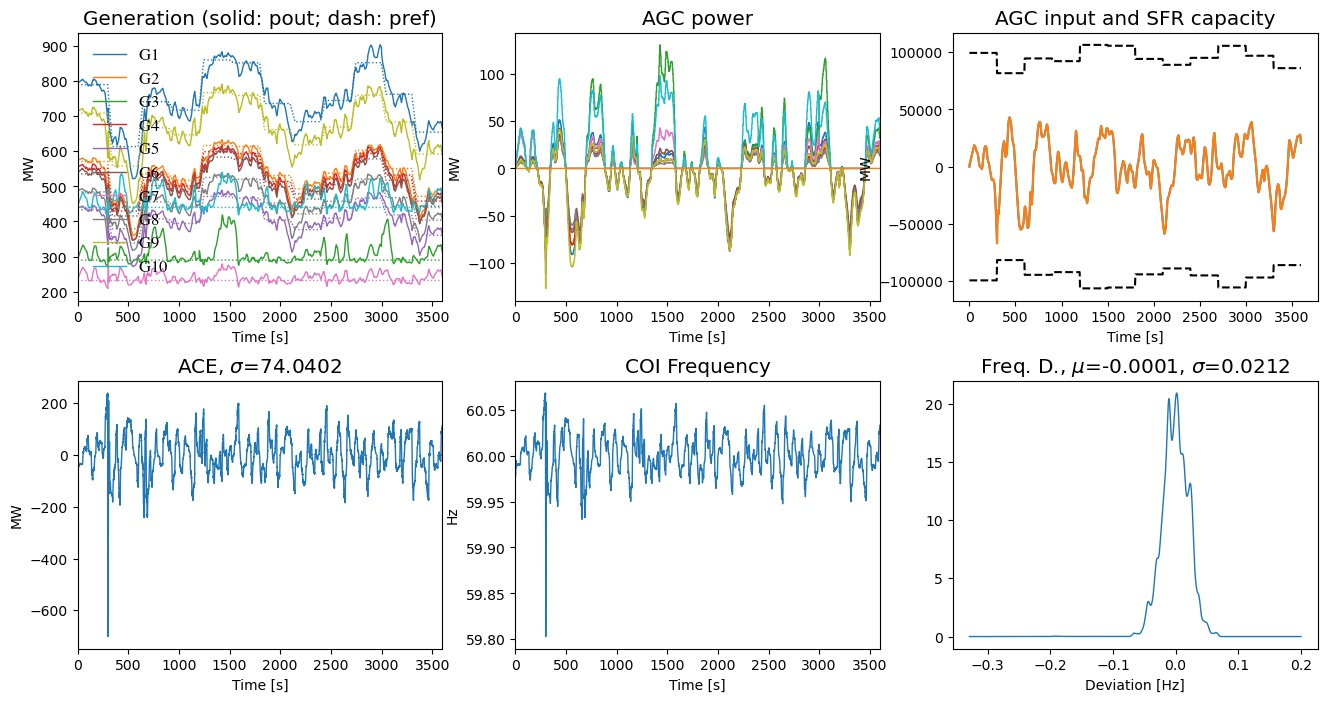

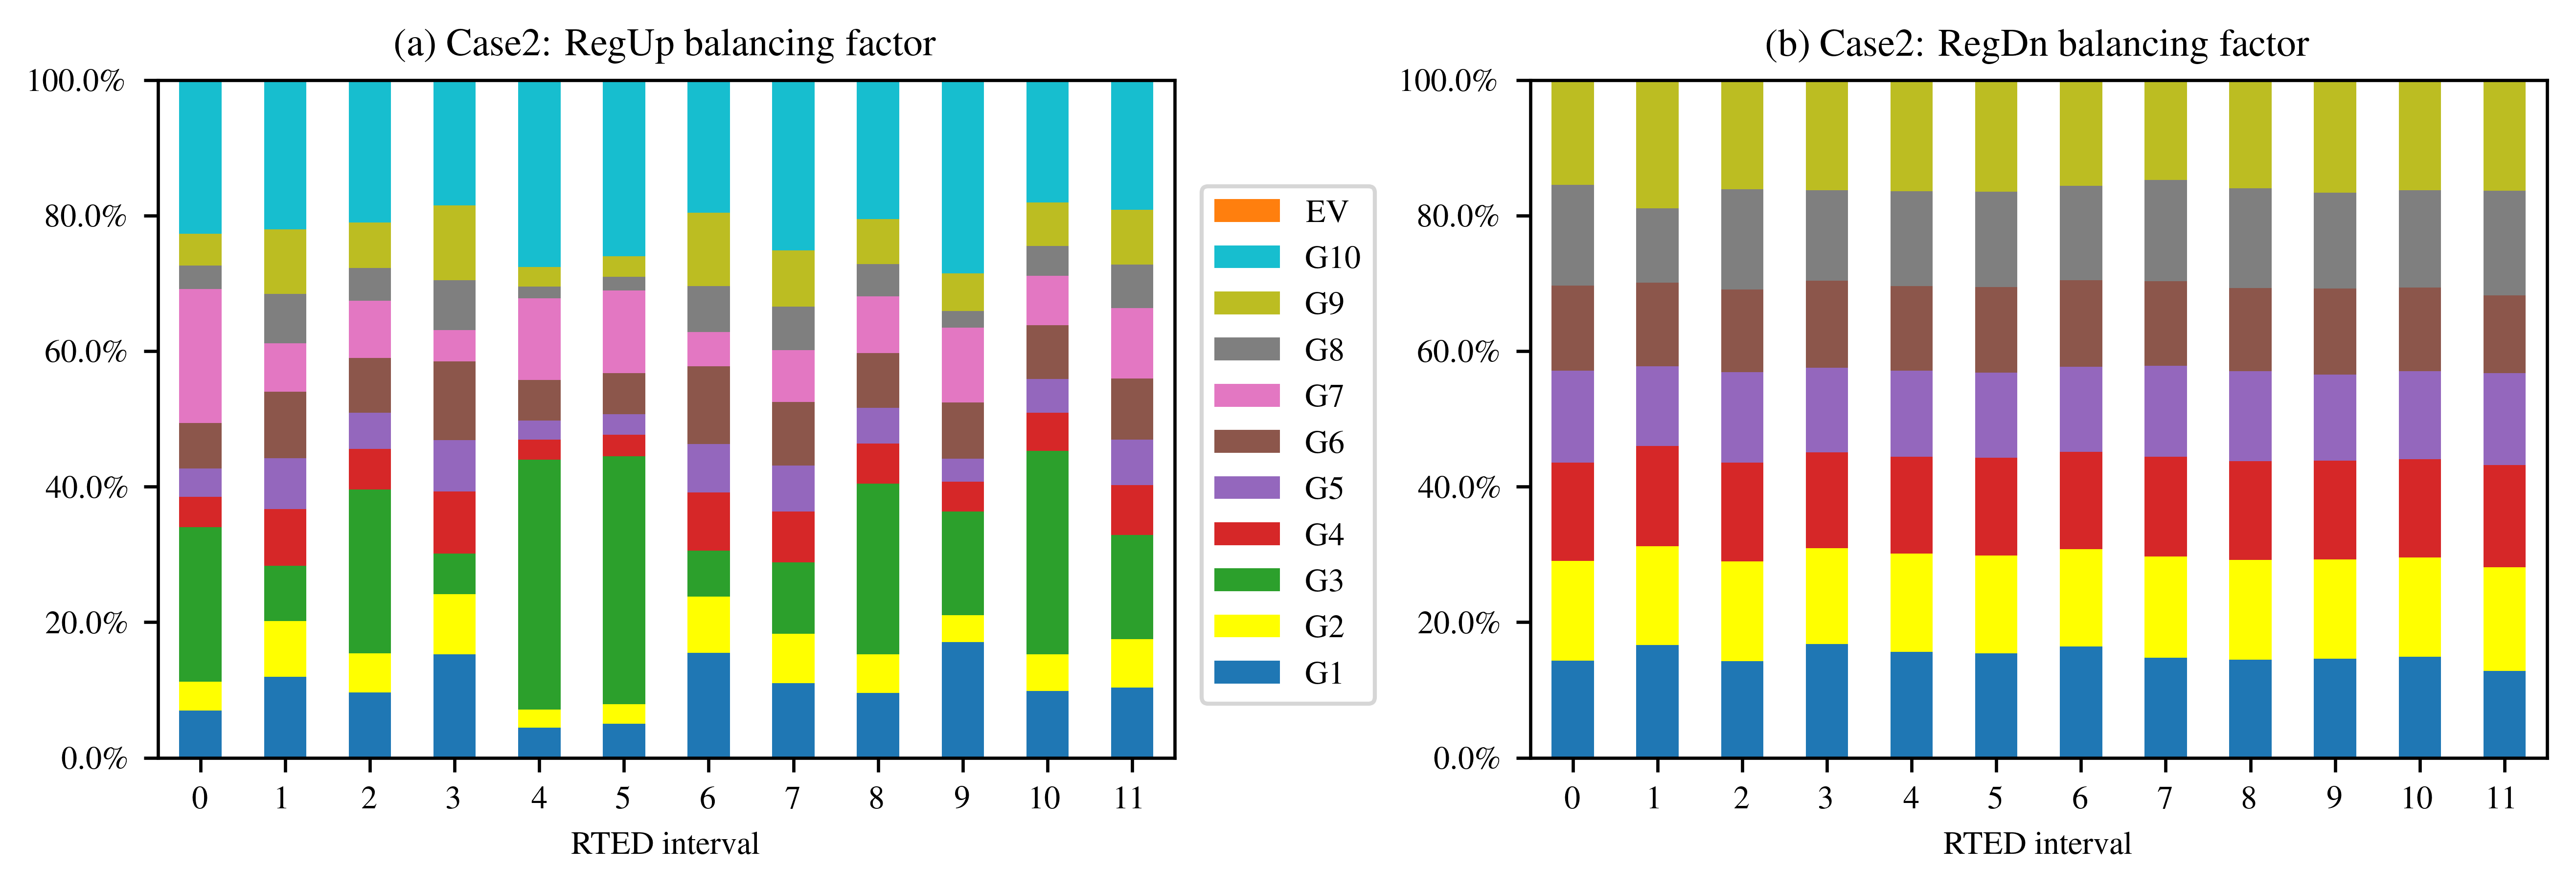

In [17]:
plt.style.use('default')

right = end_time

# data format conversion
sfr_res = pd.DataFrame(sfr_res_data, columns=['time', 'ace', 'up', 'dn', 'in'])
sfr_res['ace'] = sfr_res['ace'] * ssa.config.mva
sfr_res['up'] = sfr_res['up'] * ssa.config.mva
sfr_res['dn'] = sfr_res['dn'] * ssa.config.mva
sfr_res['in'] = sfr_res['in'] * ssa.config.mva

# data save
# Complement AGC table
agc_smooth = pd.DataFrame(np.repeat(agc_in[list(np.arange(0, t_total, 4))].values, 4, axis=1),
                          columns=list(np.arange(0, t_total, 1)))

fig_gen, ax_gen = plt.subplots(2, 3, figsize=(16, 8))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.2, hspace=0.3)

yheader = [f'G{i}' for i in range(1, 11)]

ssa.TDS.plt.plot(ssa.TGOV1N.pout,
                 linestyles=['-'],
                 yheader=yheader, ytimes=ssa.config.mva,
                 legend=True, show=False, right=right,
                 title=r'Generation (solid: pout; dash: pref)',
                 ylabel='MW',
                 fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.pref, ytimes=ssa.config.mva,
                 legend=False, show=False, right=right,
                 linestyles=[':'],
                 fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.paux,
                 linestyles=['-'],
                 yheader=yheader, ytimes=ssa.config.mva,
                 legend=False, show=False, right=right,
                 title=r'AGC power', ylabel='MW',
                 fig=fig_gen, ax=ax_gen[0, 1])
ssa.TDS.plt.plot(ssa.EV2.Pext, color='tab:orange',
                 linestyles=['-'],
                 yheader=yheader, ytimes=ssa.config.mva,
                 legend=False, show=False, right=right,
                 fig=fig_gen, ax=ax_gen[0, 1])

ax_gen[0, 2].plot(sfr_res.time,
                  ssa.config.mva * sfr_res['ace'],
                  label='AGC raw')
ax_gen[0, 2].plot(sfr_res.time, 
                  ssa.config.mva * sfr_res['in'],
                  label='AGC input')
ax_gen[0, 2].plot(sfr_res.time,
                  ssa.config.mva * sfr_res['up'],
                  label='SFR capacity',
                  linestyle='--', color='k')
ax_gen[0, 2].plot(sfr_res.time, 
                  ssa.config.mva * sfr_res['dn'],
                  linestyle='--', color='k')
ax_gen[0, 2].set_ylabel('MW')
ax_gen[0, 2].set_xlabel('Time [s]')
ax_gen[0, 2].set_title('AGC input and SFR capacity')

aced = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1) * ssa.config.mva
ssa.TDS.plt.plot(ssa.ACEc.ace,
                 legend=False, show=False, right=right,
                 linestyles=['-'], ytimes=ssa.config.mva,
                 title=f'ACE, $\sigma$={aced.std().round(4)}', ylabel='MW',
                 fig=fig_gen, ax=ax_gen[1, 0])

ssa.TDS.plt.plot(ssa.COI.omega,
                 legend=False, show=False, right=right,
                 linestyles=['-'], ylabel='Hz',
                 ytimes=ssa.config.freq,
                 title=r'COI Frequency',
                 fig=fig_gen, ax=ax_gen[1, 1])

f_coi = pd.DataFrame()
f_coi['f'] = ssa.dae.ts.y[:, ssa.COI.omega.a].reshape(-1).copy() * ssa.config.freq - ssa.config.freq
f_coi.plot(kind='kde', legend=False, linewidth=1,
           fig=fig_gen, ax=ax_gen[1, 2],
           title=f'Freq. D., $\mu$={f_coi.f.mean().round(4)}, $\sigma$={f_coi.f.std().round(4)}')
ax_gen[1, 2].set(xlabel='Deviation [Hz]', ylabel='')

# --- plot bu, bd ---
# --- collect data ---
irry = np.array(-1 * np.ones((n_ed, ssd.gen.shape[0])))
bu = irry.copy()
bd = irry.copy()
pg = irry.copy()
for rted_idx in rted_res.keys():
    bu[rted_idx] = pd.DataFrame.from_dict(rted_res[rted_idx]).loc['bu'].values
    bd[rted_idx] = pd.DataFrame.from_dict(rted_res[rted_idx]).loc['bd'].values
    pg[rted_idx] = pd.DataFrame.from_dict(rted_res[rted_idx]).loc['pg'].values
col = pd.DataFrame.from_dict(rted_res[rted_idx]).loc['gen']
bu_df = pd.DataFrame(bu, columns=col)
bd_df = pd.DataFrame(bd, columns=col)
pg_df = pd.DataFrame(pg, columns=col)

import matplotlib.font_manager
plt.style.use('ieee')

color = ['tab:blue', 'yellow', 'tab:green',
         'tab:red', 'tab:purple', 'tab:brown',
         'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'tab:orange']

figs, axes = plt.subplots(1, 2, figsize=(10.5, 3))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.35, hspace=None)
new_cols = ['PV_1', 'PV_2', 'PV_3', 'PV_4', 'PV_5', 'PV_6',
            'PV_7', 'PV_8', 'PV_9', 'Slack_10', 'PV_10']
bu_df[new_cols].plot.bar(stacked=True, ax=axes[0], legend=False, color=color)
bd_df[new_cols].plot.bar(stacked=True, ax=axes[1], legend=False, color=color)

for ax in axes:
    ax.tick_params(axis='x', labelrotation = 0)
    ax.set_ylim([0, 1])
    ax.set_yticklabels([f'{np.round(i*100,0)}\%' for i in np.arange(0, 1.1, 0.2)])
#     ax.set_xticklabels([i for i in range(1, n_ed, 1)])
    ax.set_xlabel('RTED interval')
axes[0].set_title('(a) Case2: RegUp balancing factor')
axes[1].set_title('(b) Case2: RegDn balancing factor')
lines_labels = [ax.get_legend_handles_labels() for ax in axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
line_plot = lines[0:11]
line_plot.reverse()
label_g = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'EV']
label_g.reverse()
figs.legend(line_plot, label_g, loc='center')

# --- generation cost ---
gtc = 0
for i in pg_df.index:
    c = ssd.cost.c2.values * np.power(pg_df.loc[i].values, 2) \
        + ssd.cost.c1.values * pg_df.loc[i].values \
        + ssd.cost.c1.values
    gtc += np.sum(c)

agc_out.fillna(0, inplace=True)
agc_out_sort = pd.merge(left=agc_out.rename(columns={'stg_idx':'idx'}),
                        right=ssd.cost[['idx']], on='idx', how='right')
agc_mile = pd.DataFrame(columns=list(np.arange(intv_agc, t_total, intv_agc)))
for col_id in np.arange(intv_agc, t_total, intv_agc):
    agc_mile[col_id] = np.abs(agc_out_sort[col_id] - agc_out_sort[int(col_id-intv_agc)])
agc_mile[agc_mile.columns] *= 100

# --- SFR mileage cost ---
ftc = 0
for i in agc_mile.columns:
    c = ssd.cost.c1.abs().values * agc_mile[i].values
    ftc += np.sum(c)

print(f"Total cost={np.round(gtc+ftc, 2)}")

# --- save data ---
cosim_out = pd.DataFrame()
cosim_out['Time'] = ssa.dae.ts.t
# alter the sign of ACE
cosim_out['ACE'] = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1).copy() * ssa.config.mva * -1
cosim_out['freq'] = ssa.dae.ts.y[:, ssa.COI.omega.a].reshape(-1).copy() * ssa.config.freq
pout9 = ssa.dae.ts.y[:, ssa.TGOV1N.pout.a[2]].reshape(-1)
pref9 = ssa.dae.ts.y[:, ssa.TGOV1N.pref.a[2]].reshape(-1)
cosim_out['paux9'] = ssa.config.mva * (pout9-pref9)


Text(0.5, 1.0, 'Load profile')

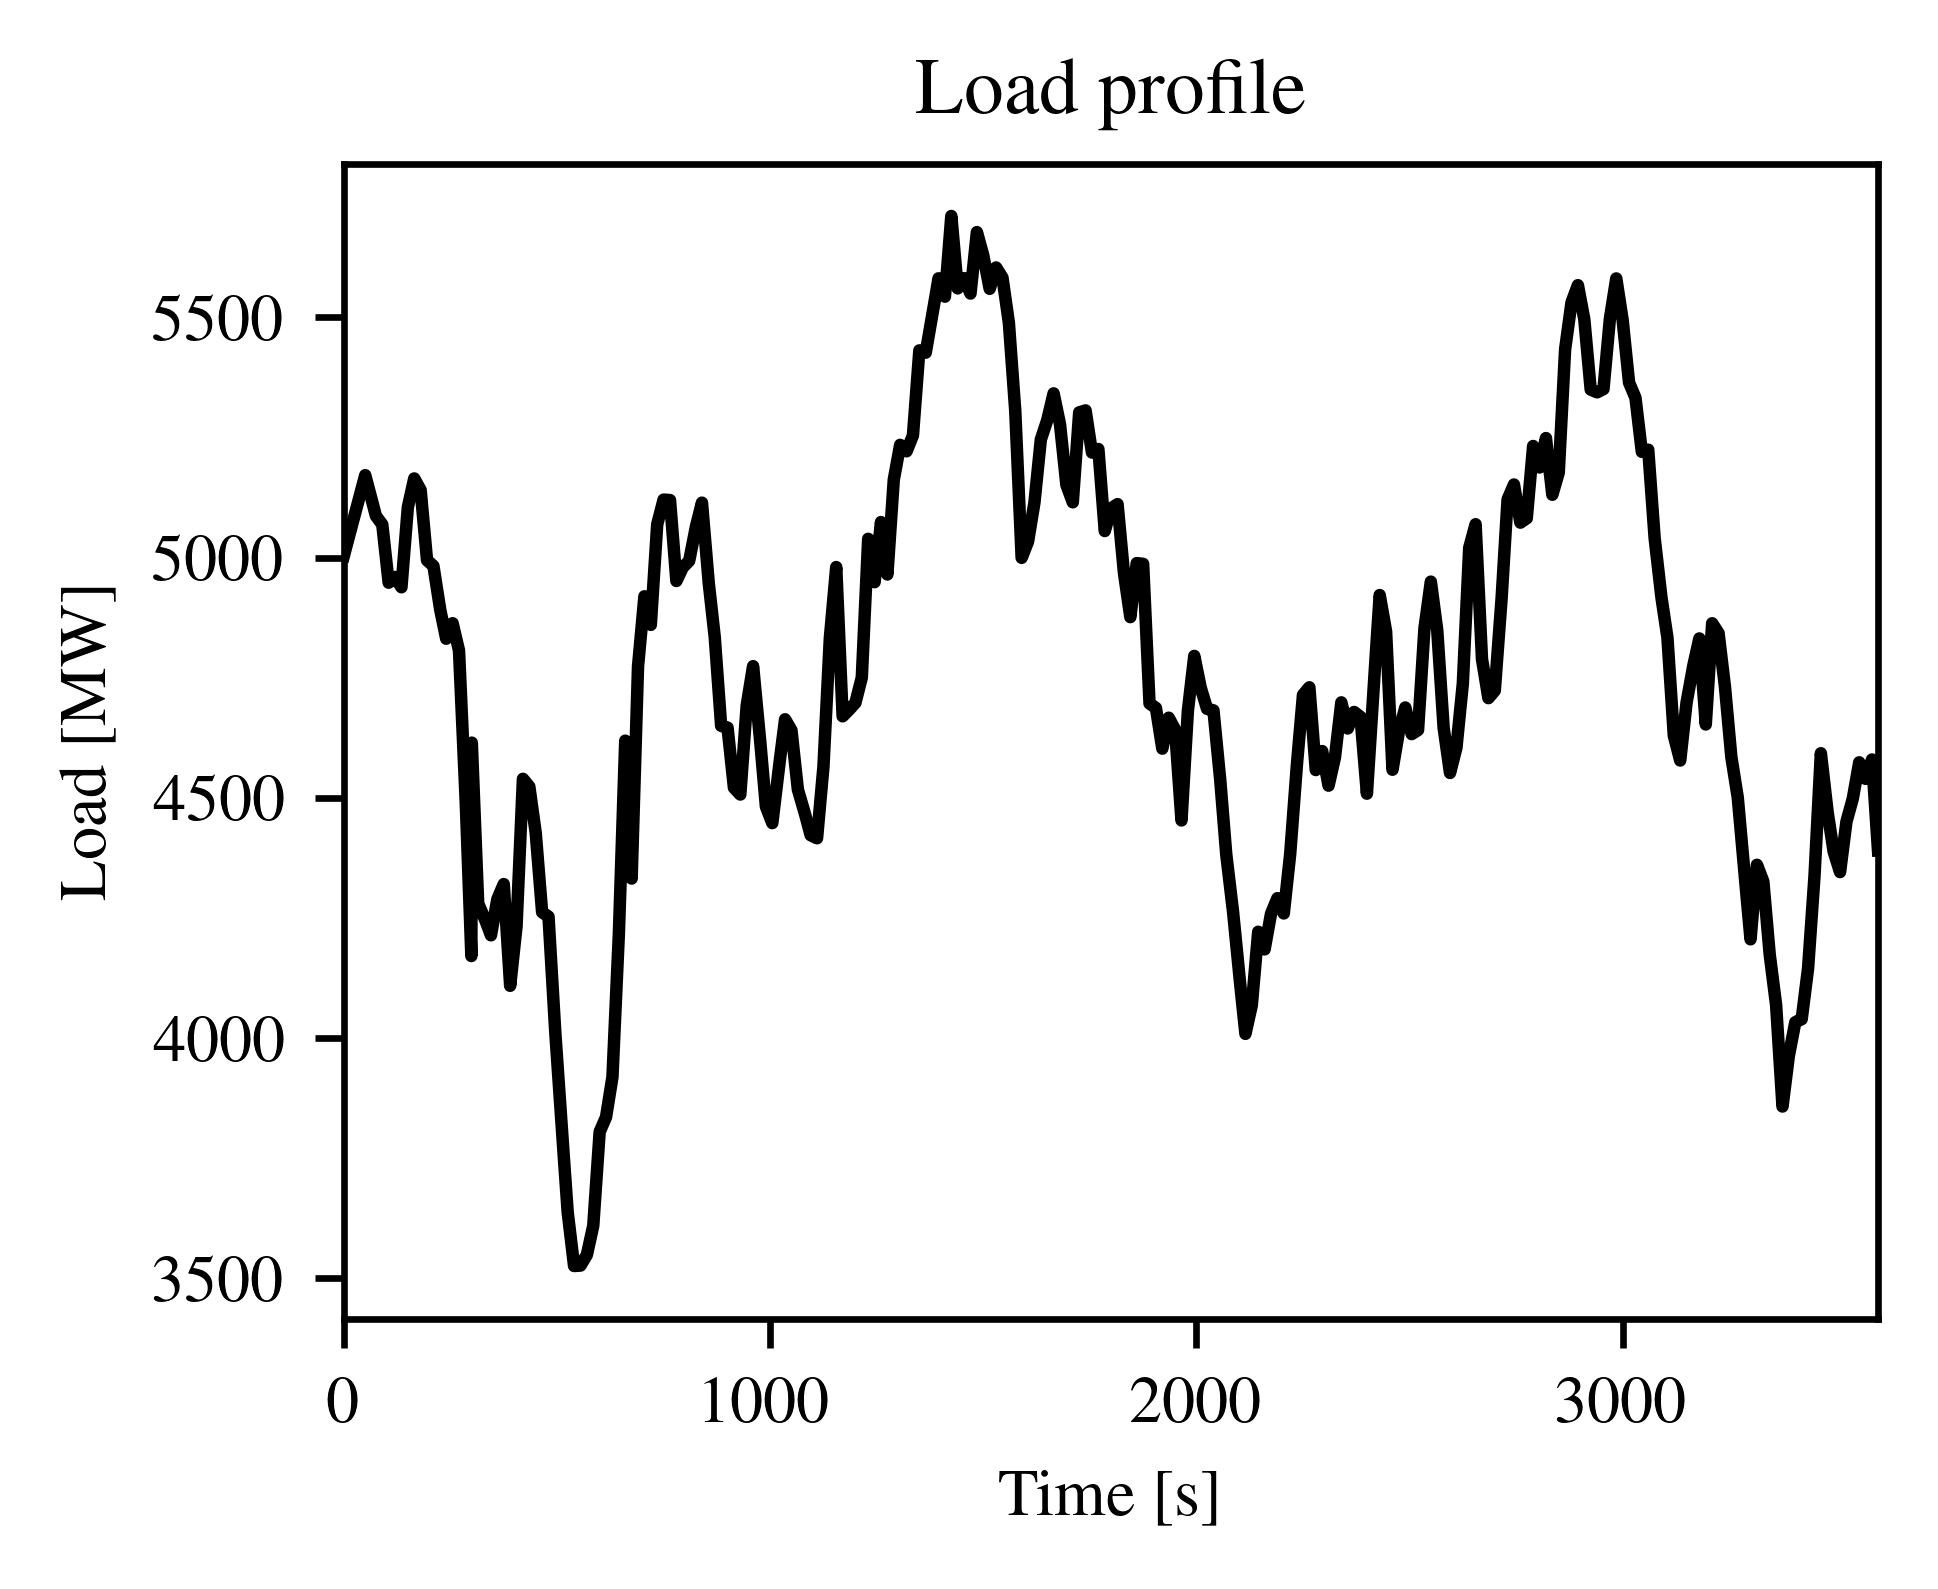

In [18]:
plt.style.use('ieee')
fig_load, ax_load = plt.subplots()
ax_load.plot(range(t_total), ssa_p0.sum() * ssa.config.mva * d_syn['sload'])
ax_load.set_xlim([0, t_total])
ax_load.set_xlabel('Time [s]')
ax_load.set_ylabel('Load [MW]')
ax_load.set_title('Load profile')

In [19]:
outdf = pd.DataFrame()
outdf['time'] = ssa.dae.ts.t
outdf['freq'] = ssa.dae.ts.y[:, ssa.COI.omega.a].reshape(-1).copy() * ssa.config.freq
outdf['fdev'] = ssa.dae.ts.y[:, ssa.COI.omega.a].reshape(-1).copy() * ssa.config.freq - ssa.config.freq
outdf['ace'] = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1).copy() * ssa.config.mva
outdf.to_csv('test_ev2.csv', index=False)

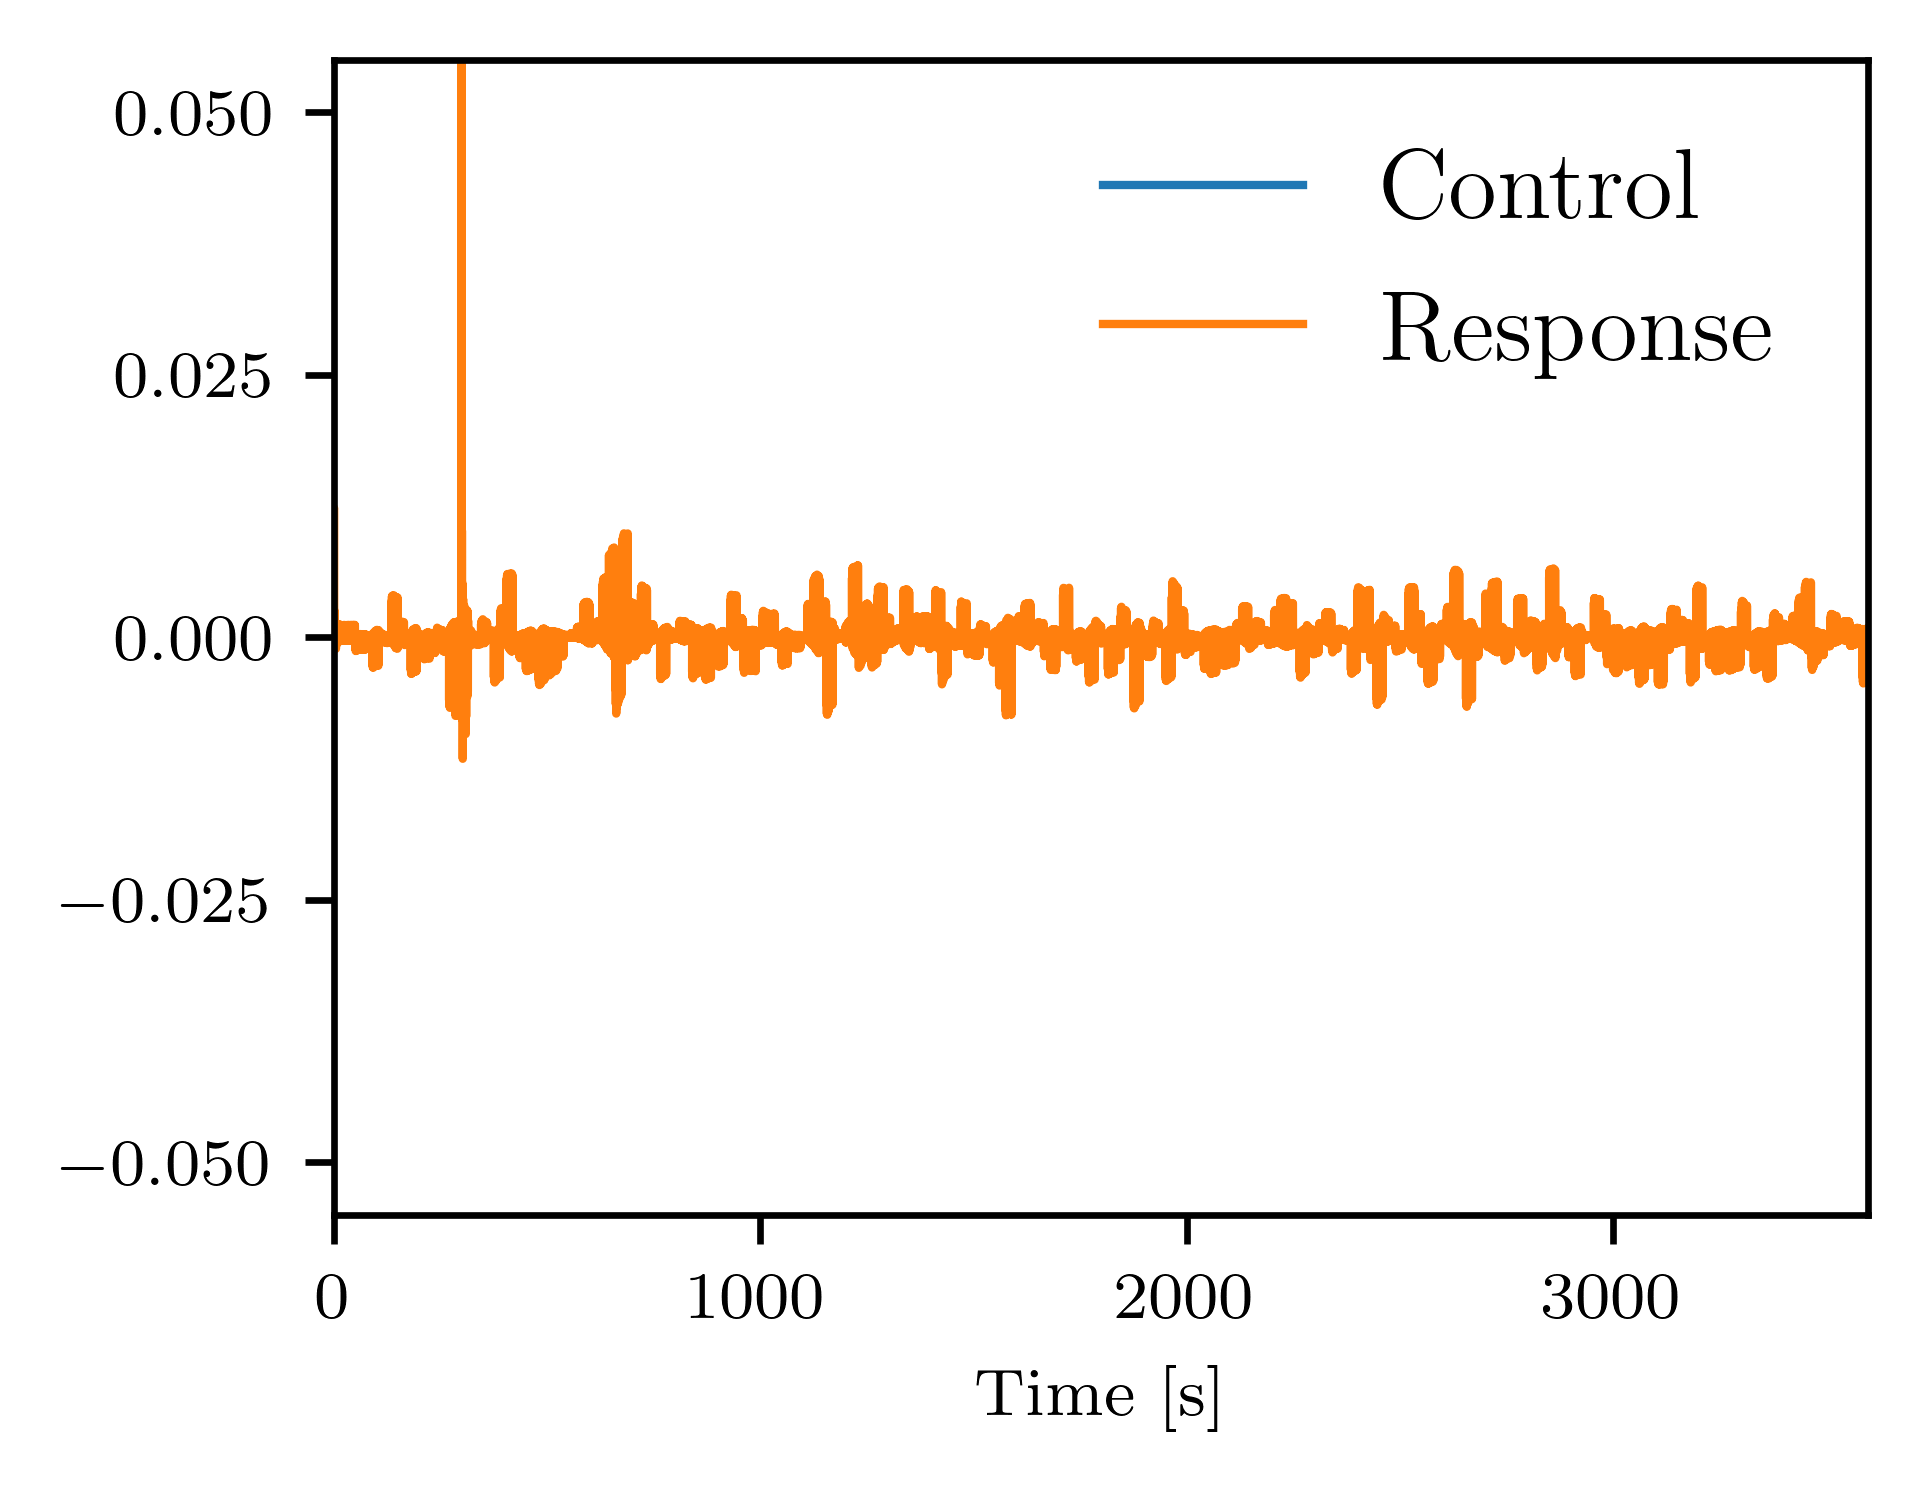

(<Figure size 1980x1500 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [20]:
# data
iev = ssa.dae.ts.x[:, ssa.EV2.Ipout_y.a]
vev = ssa.dae.ts.y[:, ssa.EV2.v.a]
pev = iev * vev
prefev = ssa.dae.ts.y[:, ssa.EV2.Pref.a]
pauxev = (pev - prefev) * ssa.config.mva

# plot
fig_e, ax_e = plt.subplots(1, 1)
ssa.TDS.plt.plot(ssa.EV2.Pext,
                 ytimes=ssa.config.mva,
                 ax=ax_e, fig=fig_e, show=False,
                 yheader=['Control'], color='tab:blue')
ssa.TDS.plt.plot_data(ssa.dae.ts.t, pauxev,
                      yheader=['Response'], color='tab:orange',
                      ax=ax_e, fig=fig_e)

In [21]:
ssa.EV2.as_df()[['ddn', 'frflag']]

,ddn,frflag
uid,,
0,0.0,0.0


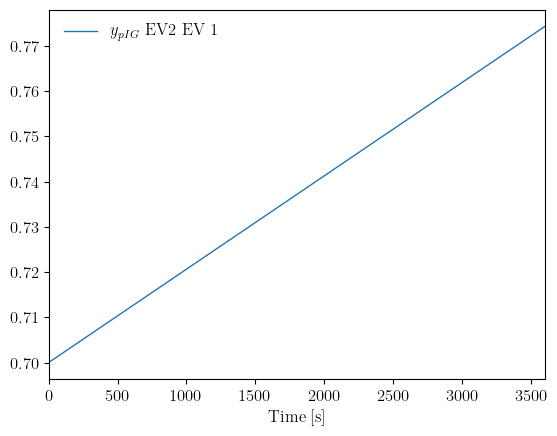

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [22]:
ssa.TDS.plt.plot(ssa.EV2.SOC)

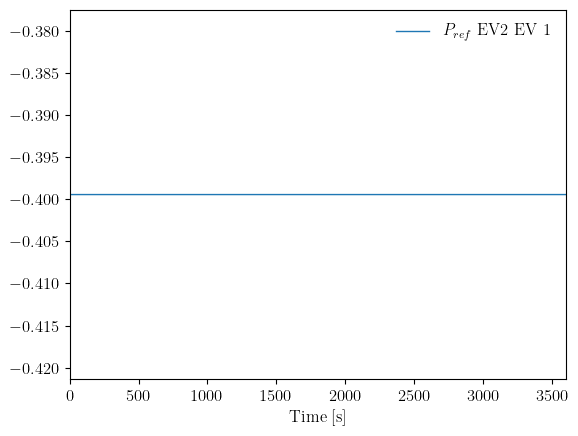

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [23]:
ssa.TDS.plt.plot(ssa.EV2.Pref)

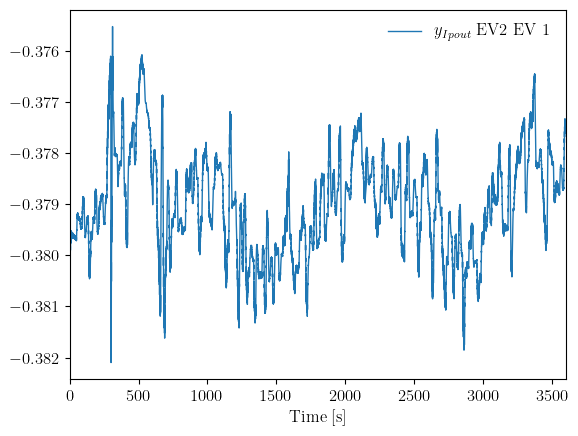

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='Time [s]'>)

In [24]:
ssa.TDS.plt.plot(ssa.EV2.Ipout_y)

In [25]:
# cosim_out.to_csv('cosim_18_S_out.csv', index=False)
# sse_out.to_csv('cosim_18_S_sse.csv', index=False)
# bu_df.to_csv('cosim_18_S_bu.csv', index=False)
# bd_df.to_csv('cosim_18_S_bd.csv', index=False)
# pg_df.to_csv('cosim_18_S_pg.csv', index=False)
# agc_mile.to_csv('cosim_18_S_agcm.csv', index=False)
# sfr_res.to_csv('cosim_18_S_sfr.csv', index=False)
# ev_agc.to_csv('cosim_18_S_evagc.csv', index=False)
# ev_soc.to_csv('cosim_18_S_evsoc.csv', index=False)
# sse.ev.to_csv('cosim_18_S_evdata.csv', index=False)

# import csv
# new_path = open('cosim_18_S_rted.csv', 'w')
# z = csv.writer(new_path)
# for new_k, new_v in rted_res.items():
#     z.writerow([new_k, new_v])
# new_path.close()